In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate_counterfactual_fidelity, get_complexity
from surrogate_tree import train_surrogate_tree, tree_to_rules, plot_surrogate_tree,\
                 get_feature_importances, plot_feature_importances, plot_tree_leafs_for_class,\
                 tree_to_constraint_matrix, constraint_matrix_to_rules, extract_rules, print_rules,\
                 evaluate
from tasks.feature_ignored import make_task

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
with open('ground_truth.(0, 1).pickle', 'rb') as f:
    ground_truth_instance_indices_01, ground_truth_01 = pickle.load(f)
with open('ground_truth.(1, 0).pickle', 'rb') as f:
    ground_truth_instance_indices_10, ground_truth_10 = pickle.load(f)

In [6]:
global_fidelities = {}
local_fidelities = {}
complexities = {}

## Tree with Depth 2

In [7]:
%%time
max_depth = 2
model = train_surrogate_tree(X, mclass_diff, max_depth=max_depth)

CPU times: user 2.18 ms, sys: 1.84 ms, total: 4.02 ms
Wall time: 14.4 ms


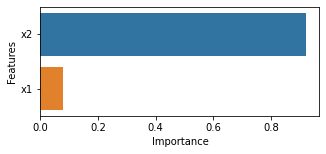

In [8]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order)

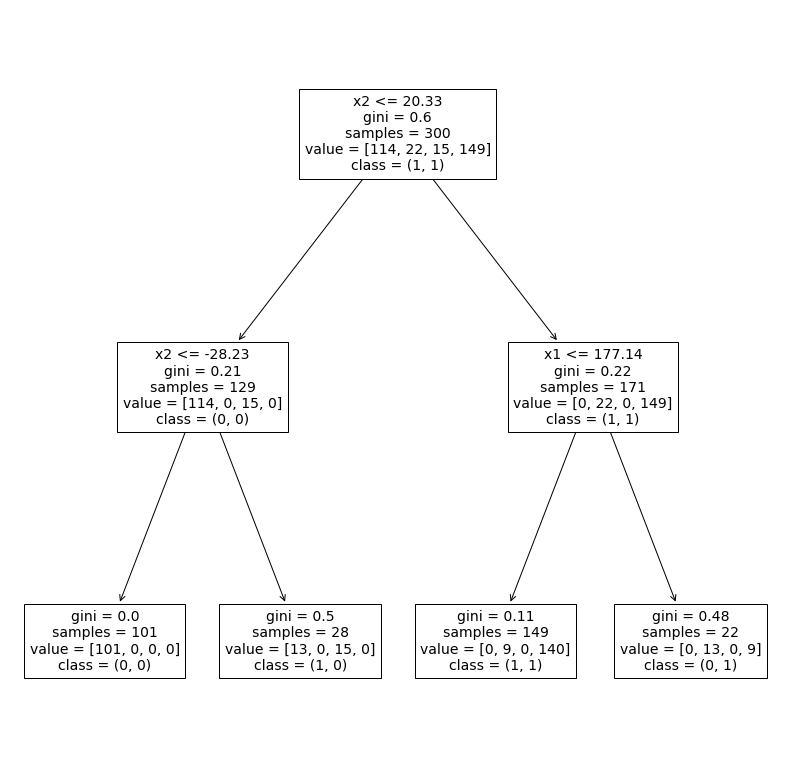

In [9]:
plot_surrogate_tree(model, feature_names, comparer.class_names, precision=2)

In [10]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -28.23253631591797 < x2 <= 20.327235221862793 => (1, 0) [13, 0, 15, 0]
2. x1 > 177.13912963867188 and x2 > 20.327235221862793 => (0, 1) [0, 13, 0, 9]


In [11]:
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       1.00      0.89      0.94       114
      (0, 1)       0.59      0.59      0.59        22
      (1, 0)       0.54      1.00      0.70        15
      (1, 1)       0.94      0.94      0.94       149

    accuracy                           0.90       300
   macro avg       0.77      0.85      0.79       300
weighted avg       0.92      0.90      0.90       300



,Precision,Recall,F1 Score,Support
"(0, 0)",1.000000,0.885965,0.939535,114.0
"(0, 1)",0.590909,0.590909,0.590909,22.0
"(1, 0)",0.535714,1.000000,0.697674,15.0
"(1, 1)",0.939597,0.939597,0.939597,149.0


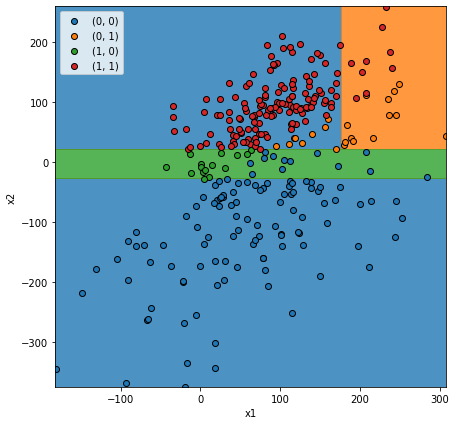

In [12]:
plot_tree_leafs_for_class(model, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names)

### Evaluation

In [13]:
constraints_01 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(0, 1)')[0]]
constraints_10 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(1, 0)')[0]]

In [14]:
instance_indices_per_rule_01 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(0, 1)')[0]]
instance_indices_per_rule_10 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(1, 0)')[0]]

#### Global Fidelity

In [15]:
global_fidelities[max_depth] = evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       1.00      0.89      0.94       114
      (0, 1)       0.59      0.59      0.59        22
      (1, 0)       0.54      1.00      0.70        15
      (1, 1)       0.94      0.94      0.94       149

    accuracy                           0.90       300
   macro avg       0.77      0.85      0.79       300
weighted avg       0.92      0.90      0.90       300



#### Counterfactual Fidelity Error

In [16]:
errors, statistics evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_01,
                                                    ground_truth_01, instance_indices_per_rule_01,
                                                    constraints_01)

In [17]:
local_fidelities[(max_depth, '(0, 1)')] = statistics
statistics

,RMSE,BMR,BAR
x1,56.719973,0.0,0.0
x2,1.023210,0.5,0.0


In [18]:
errors, statistics \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_10, ground_truth_10, instance_indices_per_rule_10, constraints_10)

invalid value encountered in true_divide


In [19]:
local_fidelities[(max_depth, '(1, 0)')] = statistics
statistics

,RMSE,BMR,BAR
x1,NaN,1.0,NaN
x2,14.289193,0.0,0.0


#### Complexity

In [20]:
res = get_complexity(constraints_01)
complexities[(max_depth, '(0, 1)')] = res
res

Rules          1
Constraints    2
dtype: int64

In [21]:
res = get_complexity(constraints_10)
complexities[(max_depth, '(1, 0)')] = res
res

Rules          1
Constraints    2
dtype: int64

## Tree with Depth 3

In [22]:
%%time
max_depth = 3
model = train_surrogate_tree(X, mclass_diff, max_depth=max_depth)

CPU times: user 1.4 ms, sys: 188 µs, total: 1.58 ms
Wall time: 2.24 ms


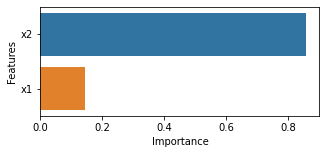

In [23]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order)

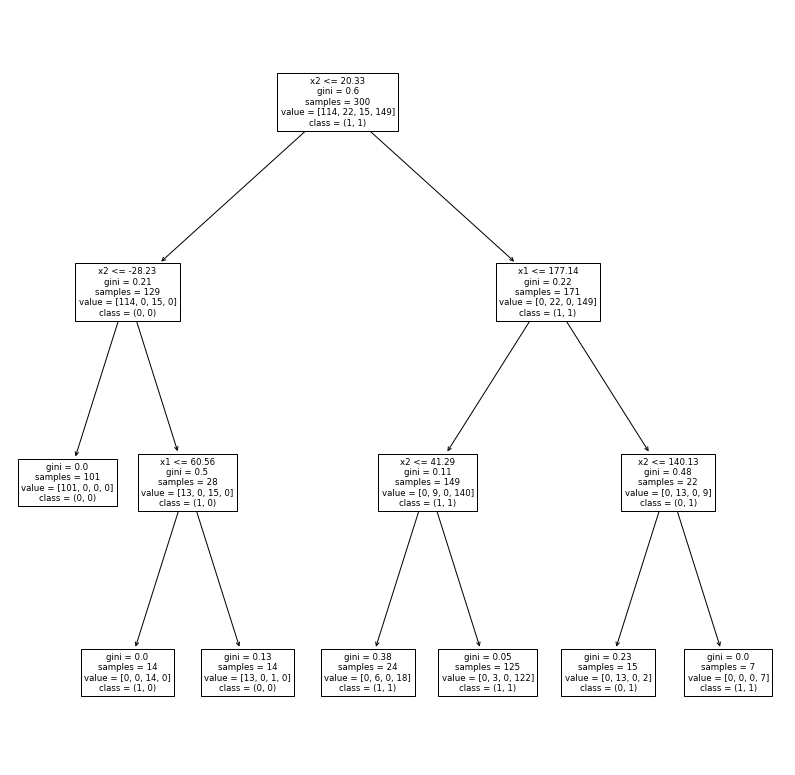

In [24]:
plot_surrogate_tree(model, feature_names, comparer.class_names, precision=2)

In [25]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 177.13912963867188 and 20.327235221862793 < x2 <= 140.12899017333984 => (0, 1) [0, 13, 0, 2]
2. x1 <= 60.555185317993164 and -28.23253631591797 < x2 <= 20.327235221862793 => (1, 0) [0, 0, 14, 0]


In [26]:
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       0.99      1.00      1.00       114
      (0, 1)       0.87      0.59      0.70        22
      (1, 0)       1.00      0.93      0.97        15
      (1, 1)       0.94      0.99      0.96       149

    accuracy                           0.96       300
   macro avg       0.95      0.88      0.91       300
weighted avg       0.96      0.96      0.96       300



,Precision,Recall,F1 Score,Support
"(0, 0)",0.991304,1.000000,0.995633,114.0
"(0, 1)",0.866667,0.590909,0.702703,22.0
"(1, 0)",1.000000,0.933333,0.965517,15.0
"(1, 1)",0.942308,0.986577,0.963934,149.0


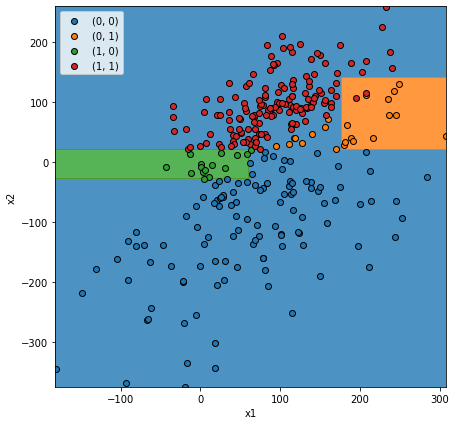

In [27]:
plot_tree_leafs_for_class(model, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names)

### Evaluation

In [28]:
constraints_01 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(0, 1)')[0]]
constraints_10 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(1, 0)')[0]]

In [29]:
instance_indices_per_rule_01 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(0, 1)')[0]]
instance_indices_per_rule_10 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(1, 0)')[0]]

#### Global Fidelity

In [30]:
global_fidelities[max_depth] = evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       0.99      1.00      1.00       114
      (0, 1)       0.87      0.59      0.70        22
      (1, 0)       1.00      0.93      0.97        15
      (1, 1)       0.94      0.99      0.96       149

    accuracy                           0.96       300
   macro avg       0.95      0.88      0.91       300
weighted avg       0.96      0.96      0.96       300



#### Counterfactual Fidelity Error

In [31]:
errors, statistics \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_01, ground_truth_01, instance_indices_per_rule_01, constraints_01)

In [32]:
local_fidelities[(max_depth, '(0, 1)')] = statistics
statistics

,RMSE,BMR,BAR
x1,56.719973,0.0,0.0
x2,21.719044,0.0,0.0


In [33]:
errors, statistics \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_10, ground_truth_10, instance_indices_per_rule_10, constraints_10)

In [34]:
local_fidelities[(max_depth, '(1, 0)')] = statistics
statistics

,RMSE,BMR,BAR
x1,25.511318,0.0,0.0
x2,13.079858,0.0,0.0


#### Complexity

In [35]:
res = get_complexity(constraints_01)
complexities[(max_depth, '(0, 1)')] = res
res

Rules          1
Constraints    3
dtype: int64

In [36]:
res = get_complexity(constraints_10)
complexities[(max_depth, '(1, 0)')] = res
res

Rules          1
Constraints    3
dtype: int64

## Tree with Depth 4

In [37]:
%%time
max_depth = 4
model = train_surrogate_tree(X, mclass_diff, max_depth=max_depth)

CPU times: user 1.9 ms, sys: 1.69 ms, total: 3.58 ms
Wall time: 2.61 ms


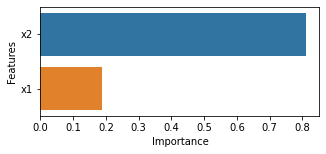

In [38]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order)

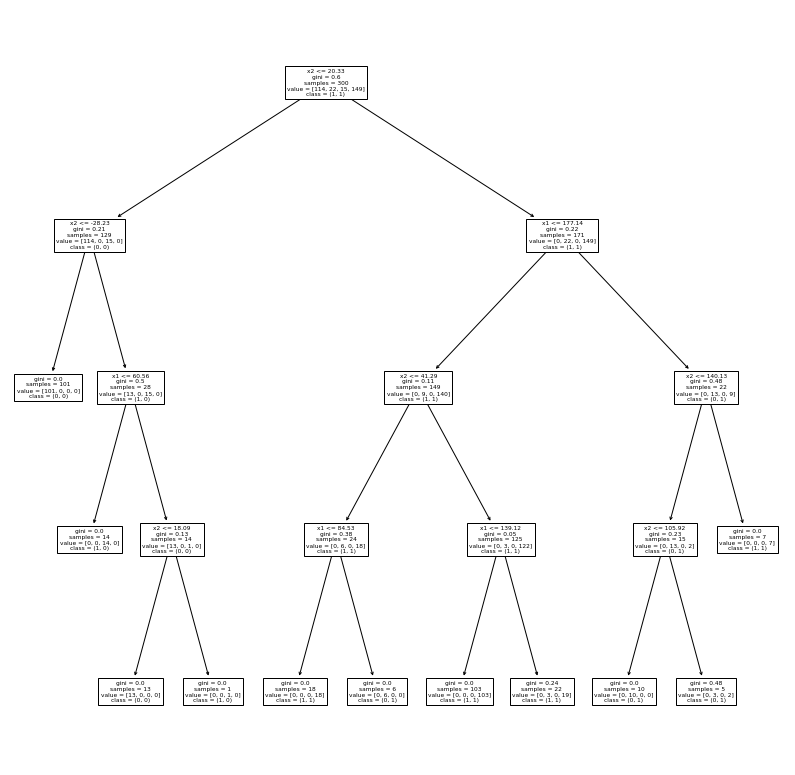

In [39]:
plot_surrogate_tree(model, feature_names, comparer.class_names, precision=2)

In [40]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 60.555185317993164 and -28.23253631591797 < x2 <= 20.327235221862793 => (1, 0) [0, 0, 14, 0]
2. x1 > 177.13912963867188 and 20.327235221862793 < x2 <= 105.91933059692383 => (0, 1) [0, 10, 0, 0]
3. 84.53179931640625 < x1 <= 177.13912963867188 and 20.327235221862793 < x2 <= 41.294612884521484 => (0, 1) [0, 6, 0, 0]
4. x1 > 177.13912963867188 and 105.91933059692383 < x2 <= 140.12899017333984 => (0, 1) [0, 3, 0, 2]
5. x1 > 60.555185317993164 and 18.090243339538574 < x2 <= 20.327235221862793 => (1, 0) [0, 0, 1, 0]


In [41]:
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       1.00      1.00      1.00       114
      (0, 1)       0.90      0.86      0.88        22
      (1, 0)       1.00      1.00      1.00        15
      (1, 1)       0.98      0.99      0.98       149

    accuracy                           0.98       300
   macro avg       0.97      0.96      0.97       300
weighted avg       0.98      0.98      0.98       300



,Precision,Recall,F1 Score,Support
"(0, 0)",1.000000,1.000000,1.000000,114.0
"(0, 1)",0.904762,0.863636,0.883721,22.0
"(1, 0)",1.000000,1.000000,1.000000,15.0
"(1, 1)",0.980000,0.986577,0.983278,149.0


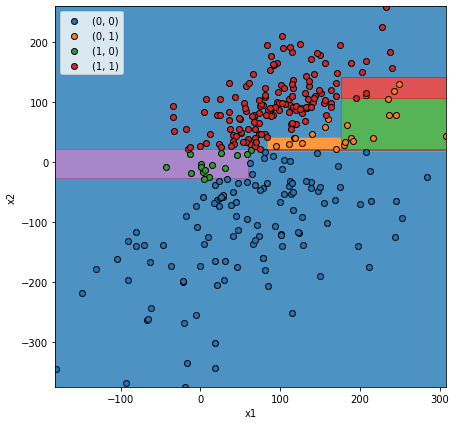

In [42]:
plot_tree_leafs_for_class(model, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names)

### Evaluation

In [43]:
constraints_01 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(0, 1)')[0]]
constraints_10 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(1, 0)')[0]]

In [44]:
instance_indices_per_rule_01 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(0, 1)')[0]]
instance_indices_per_rule_10 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(1, 0)')[0]]

#### Global Fidelity

In [45]:
global_fidelities[max_depth] = evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       1.00      1.00      1.00       114
      (0, 1)       0.90      0.86      0.88        22
      (1, 0)       1.00      1.00      1.00        15
      (1, 1)       0.98      0.99      0.98       149

    accuracy                           0.98       300
   macro avg       0.97      0.96      0.97       300
weighted avg       0.98      0.98      0.98       300



#### Counterfactual Fidelity Error

In [46]:
errors, statistics \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_01, ground_truth_01, instance_indices_per_rule_01, constraints_01)

In [47]:
local_fidelities[(max_depth, '(0, 1)')] = statistics
statistics

,RMSE,BMR,BAR
x1,47.532812,0.0,0.24
x2,30.447206,0.0,0.00


In [48]:
errors, statistics \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_10, ground_truth_10, instance_indices_per_rule_10, constraints_10)

In [49]:
local_fidelities[(max_depth, '(1, 0)')] = statistics
statistics

,RMSE,BMR,BAR
x1,25.511318,0.066667,0.066667
x2,12.763699,0.000000,0.000000


#### Complexity

In [50]:
res = get_complexity(constraints_01)
complexities[(max_depth, '(0, 1)')] = res
res

Rules           3
Constraints    10
dtype: int64

In [51]:
res = get_complexity(constraints_10)
complexities[(max_depth, '(1, 0)')] = res
res

Rules          2
Constraints    6
dtype: int64

## Tree with Depth 5

In [52]:
%%time
max_depth = 5
model = train_surrogate_tree(X, mclass_diff, max_depth=max_depth)

CPU times: user 1.68 ms, sys: 1.24 ms, total: 2.92 ms
Wall time: 2.73 ms


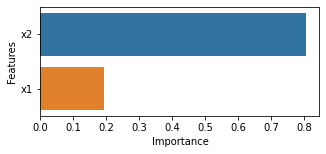

In [53]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order)

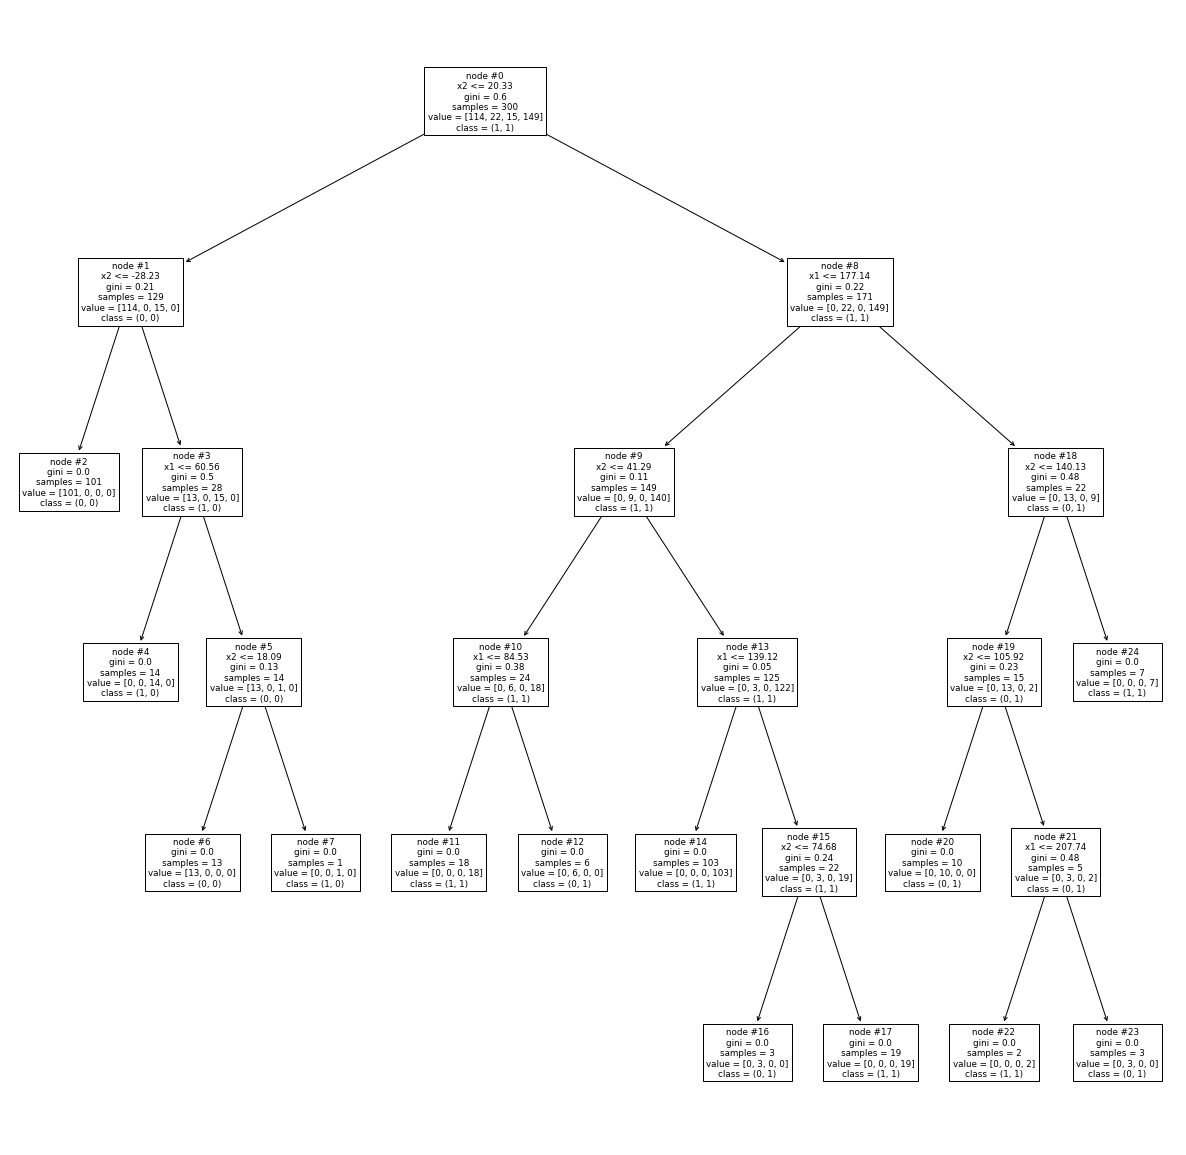

In [54]:
plot_surrogate_tree(model, feature_names, comparer.class_names, precision=2, figsize=(21, 21), node_ids=True)

In [55]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 60.555185317993164 and -28.23253631591797 < x2 <= 20.327235221862793 => (1, 0) [0, 0, 14, 0]
2. x1 > 177.13912963867188 and 20.327235221862793 < x2 <= 105.91933059692383 => (0, 1) [0, 10, 0, 0]
3. 84.53179931640625 < x1 <= 177.13912963867188 and 20.327235221862793 < x2 <= 41.294612884521484 => (0, 1) [0, 6, 0, 0]
4. x1 > 207.73780059814453 and 105.91933059692383 < x2 <= 140.12899017333984 => (0, 1) [0, 3, 0, 0]
5. 139.11507415771484 < x1 <= 177.13912963867188 and 41.294612884521484 < x2 <= 74.68447494506836 => (0, 1) [0, 3, 0, 0]
6. x1 > 60.555185317993164 and 18.090243339538574 < x2 <= 20.327235221862793 => (1, 0) [0, 0, 1, 0]


In [56]:
evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       1.00      1.00      1.00       114
      (0, 1)       1.00      1.00      1.00        22
      (1, 0)       1.00      1.00      1.00        15
      (1, 1)       1.00      1.00      1.00       149

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



,Precision,Recall,F1 Score,Support
"(0, 0)",1.0,1.0,1.0,114.0
"(0, 1)",1.0,1.0,1.0,22.0
"(1, 0)",1.0,1.0,1.0,15.0
"(1, 1)",1.0,1.0,1.0,149.0


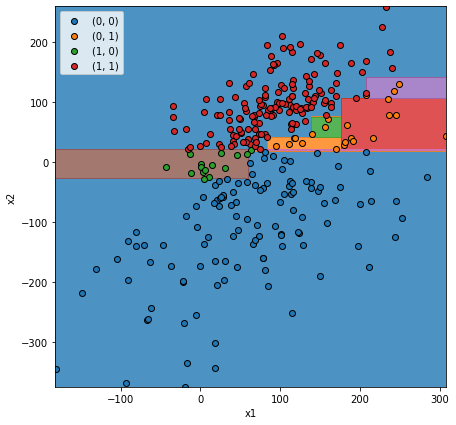

In [57]:
plot_tree_leafs_for_class(model, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names)

### Evaluation

In [58]:
constraints_01 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(0, 1)')[0]]
constraints_10 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(1, 0)')[0]]

In [59]:
instance_indices_per_rule_01 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(0, 1)')[0]]
instance_indices_per_rule_10 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(1, 0)')[0]]

#### Global Fidelity

In [60]:
global_fidelities[max_depth] = evaluate(model, X, mclass_diff, comparer.class_names)

              precision    recall  f1-score   support

      (0, 0)       1.00      1.00      1.00       114
      (0, 1)       1.00      1.00      1.00        22
      (1, 0)       1.00      1.00      1.00        15
      (1, 1)       1.00      1.00      1.00       149

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



#### Counterfactual Fidelity Error

In [61]:
errors, statistics \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_01, ground_truth_01, instance_indices_per_rule_01, constraints_01)

In [62]:
local_fidelities[(max_depth, '(0, 1)')] = statistics
statistics

,RMSE,BMR,BAR
x1,42.471898,0.0,0.290323
x2,28.821990,0.0,0.000000


In [63]:
errors, statistics \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_10, ground_truth_10, instance_indices_per_rule_10, constraints_10)

In [64]:
local_fidelities[(max_depth, '(1, 0)')] = statistics
statistics

,RMSE,BMR,BAR
x1,25.511318,0.066667,0.066667
x2,12.763699,0.000000,0.000000


#### Complexity

In [65]:
res = get_complexity(constraints_01)
complexities[(max_depth, '(0, 1)')] = res
res

Rules           4
Constraints    14
dtype: int64

In [66]:
res = get_complexity(constraints_10)
complexities[(max_depth, '(1, 0)')] = res
res

Rules          2
Constraints    6
dtype: int64

# Summary

In [67]:
def map_index(index):
    class_, depth = index[0], index[1]
    if depth == 3:
        level = 'global'
    elif depth == 5:
        level = 'local'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [68]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('depth', 'class'))
global_fidelity = global_fidelity[np.in1d(global_fidelity.index.get_level_values('class'), comparer.difference_class_names)]
global_fidelity = global_fidelity.reorder_levels(['class', 'depth']).sort_index()
global_fidelity

Precision    Recall  F1 Score  Support
class  depth                                        
(0, 1) 2       0.590909  0.590909  0.590909     22.0
       3       0.866667  0.590909  0.702703     22.0
       4       0.904762  0.863636  0.883721     22.0
       5       1.000000  1.000000  1.000000     22.0
(1, 0) 2       0.535714  1.000000  0.697674     15.0
       3       1.000000  0.933333  0.965517     15.0
       4       1.000000  1.000000  1.000000     15.0
       5       1.000000  1.000000  1.000000     15.0

## Local Fidelity

In [69]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('depth', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'depth', 'feature']).sort_index()
local_fidelity

RMSE       BMR       BAR
class  depth feature                               
(0, 1) 2     x1       56.719973  0.000000  0.000000
             x2        1.023210  0.500000  0.000000
       3     x1       56.719973  0.000000  0.000000
             x2       21.719044  0.000000  0.000000
       4     x1       47.532812  0.000000  0.240000
             x2       30.447206  0.000000  0.000000
       5     x1       42.471898  0.000000  0.290323
             x2       28.821990  0.000000  0.000000
(1, 0) 2     x1             NaN  1.000000       NaN
             x2       14.289193  0.000000  0.000000
       3     x1       25.511318  0.000000  0.000000
             x2       13.079858  0.000000  0.000000
       4     x1       25.511318  0.066667  0.066667
             x2       12.763699  0.000000  0.000000
       5     x1       25.511318  0.066667  0.066667
             x2       12.763699  0.000000  0.000000

## Complexity

In [70]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('depth', 'class')).T
complexity = complexity.reorder_levels(['class', 'depth']).sort_index()
complexity

Rules  Constraints
class  depth                    
(0, 1) 2          1            2
       3          1            3
       4          3           10
       5          4           14
(1, 0) 2          1            2
       3          1            3
       4          2            6
       5          2            6

## Generation Time

<1s

In [71]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('depth').notnull()]
global_fidelity.index.rename(['class', 'level'], inplace=True)

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('depth').notnull()]
local_fidelity.index.rename(['class', 'level', 'feature'], inplace=True)

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('depth').notnull()]
complexity.index.rename(['class', 'level'], inplace=True)

with open('results.baseline.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)